In [ ]:
import pandas as pd
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, average_precision_score, roc_curve, precision_recall_curve
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from sklearn.metrics import make_scorer

# Definición de métricas

In [ ]:
def lift_top_k(y_true, y_scores, top_percent=0.10):
    df = pd.DataFrame({'y_true': y_true, 'y_score': y_scores})
    df = df.sort_values(by='y_score', ascending=False)

    top_k_count = int(len(df) * top_percent)
    df_top = df.head(top_k_count)
    positives_top_k = df_top['y_true'].sum()
    positives_total = df['y_true'].sum()
    baseline_rate = positives_total / len(df)
    top_k_rate = positives_top_k / top_k_count
    lift = top_k_rate / baseline_rate
    recall_top_k = positives_top_k / positives_total

    print(f"Clientes en top {int(top_percent*100)}%: {top_k_count}")
    print(f"Positivos en top {int(top_percent*100)}%: {positives_top_k}")
    print(f"Tasa en top {int(top_percent*100)}%: {top_k_rate:.4f}")
    print(f"Tasa global: {baseline_rate:.4f}")
    print(f"Lift {int(top_percent*100)}%: {lift:.2f}")
    print(f"Recall @ top {int(top_percent*100)}%: {recall_top_k:.4f}")
    return lift

def lift_score(y_true, y_scores, top_percent=0.20):
    df = pd.DataFrame({'y_true': y_true, 'y_score': y_scores})
    df = df.sort_values(by='y_score', ascending=False)

    top_k_count = int(len(df) * top_percent)
    df_top = df.head(top_k_count)

    positives_top_k = df_top['y_true'].sum()
    positives_total = df['y_true'].sum()

    baseline_rate = positives_total / len(df)
    top_k_rate = positives_top_k / top_k_count
    lift = top_k_rate / baseline_rate

    return lift

def lift_scorer(estimator, X, y):
    y_scores = estimator.predict_proba(X)[:, 1]
    return lift_score(y, y_scores, top_percent=0.20)

In [ ]:
def evaluar_modelo(modelo, X_test, y_test, top_percent=0.20):
    print("="*30)
    print("Evaluación del modelo")

    # Probabilidades y predicción
    y_scores = modelo.predict_proba(X_test)[:, 1]
    y_pred = modelo.predict(X_test)

    # LIFT
    lift = lift_top_k(y_test, y_scores, top_percent=top_percent)
    print("="*30)
    print(f"LIFT en el top {int(top_percent*100)}%:")
    print(f"Lift {int(top_percent*100)}%: {lift:.2f}")

    # Matriz de confusión
    print("="*30)
    print("Matriz de Confusión:")
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.xlabel("Predicción")
    plt.ylabel("Real")
    plt.title("Matriz de Confusión")
    plt.show()

    # Reporte de clasificación
    print("="*30)
    print("Classification Report:")
    print(classification_report(y_test, y_pred, target_names=["No CARAVAN", "CARAVAN"]))

    # AUC-ROC
    roc_auc = roc_auc_score(y_test, y_scores)
    print("="*30)
    print(f"AUC-ROC: {roc_auc:.4f}")

    # AUC-PR
    pr_auc = average_precision_score(y_test, y_scores)
    print(f"Área bajo la curva Precision-Recall (PR AUC): {pr_auc:.4f}")

    # Curvas ROC y PR
    fpr, tpr, _ = roc_curve(y_test, y_scores)
    precision, recall, _ = precision_recall_curve(y_test, y_scores)

    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(fpr, tpr)
    plt.title('Curva ROC')
    plt.xlabel('FPR')
    plt.ylabel('TPR')

    plt.subplot(1, 2, 2)
    plt.plot(recall, precision)
    plt.title('Curva Precision-Recall')
    plt.xlabel('Recall')
    plt.ylabel('Precision')

    plt.tight_layout()
    plt.show()
    print("="*30)


# Optimizador

In [ ]:
from sklearn.naive_bayes import GaussianNB
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier

from sklearn.model_selection import StratifiedKFold, cross_val_score
import optuna

In [ ]:
def optimize_classifier(model_type, X, y, top_percent=0.20, n_trials=30, random_state=42):
    """
    Optimizador universal para múltiples algoritmos
    """
    def get_param_space(model_type, trial):
      params = {}

      def lift_scorer_func(y_true, y_scores):
        return lift_score(y_true, y_scores, top_percent=top_percent)

      if model_type == 'lgbm':
        params = {
            'objective': 'binary',
            'metric': 'average_precision',
            'scale_pos_weight': trial.suggest_float('scale_pos_weight', 1, 20),
            'n_estimators': trial.suggest_int('n_estimators', 100, 500),
            'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.2, log=True),
            'num_leaves': trial.suggest_int('num_leaves', 20, 100),
            'max_depth': trial.suggest_int('max_depth', 3, 10),
            'min_child_samples': trial.suggest_int('min_child_samples', 20, 100),
            'subsample': trial.suggest_float('subsample', 0.6, 1.0),
            'random_state': random_state,
            'n_jobs': -1
        }
      elif model_type == 'nb':
        params = {
            'var_smoothing': trial.suggest_float('var_smoothing', 1e-10, 1e-8, log=True)
        }
      elif model_type == 'xgb':
        params = {
            'objective': 'binary:logistic',
            'eval_metric': 'aucpr',
            'scale_pos_weight': trial.suggest_float('scale_pos_weight', 1, 20),
            'n_estimators': trial.suggest_int('n_estimators', 100, 500),
            'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.2, log=True),
            'max_depth': trial.suggest_int('max_depth', 3, 10),
            'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
            'subsample': trial.suggest_float('subsample', 0.6, 1.0),
            'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
            'reg_alpha': trial.suggest_float('reg_alpha', 0, 1),
            'reg_lambda': trial.suggest_float('reg_lambda', 0, 1),
            'random_state': random_state,
            'n_jobs': -1
        }
      elif model_type == 'ensemble':
        # Para ensemble, optimizamos pesos de combinación
        params = {
            'lgbm_weight': trial.suggest_float('lgbm_weight', 0.1, 0.6),
            'nb_weight': trial.suggest_float('nb_weight', 0.1, 0.4),
            'xgb_weight': trial.suggest_float('xgb_weight', 0.2, 0.6),
        }
        # Normalizar pesos para que sumen 1
        total = params['lgbm_weight'] + params['nb_weight'] + params['xgb_weight']
        params = {k: v/total for k, v in params.items()}

      return params

    def objective(trial):
      params = get_param_space(model_type, trial)

      if model_type == 'lgbm':
          model = LGBMClassifier(**params)
      elif model_type == 'nb':
          model = GaussianNB(**params)
      elif model_type == 'xgb':
          model = XGBClassifier(**params)

      # Cross-validation con lift score
      cv_scores = cross_val_score(
          model, X, y,
          cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=random_state),
          scoring=lift_scorer,
          n_jobs=-1
      )

      return cv_scores.mean()

    study = optuna.create_study(direction='maximize')
    model_names = {'lgbm': 'LGBMClassifier', 'nb': 'Native Bayes', 'xgb': 'XGBoost'}

    print(f"⚡ Optimizando {model_names[model_type]} para LIFT@{top_percent*100}%...")
    study.optimize(objective, n_trials=n_trials)

    print(f"✅ {model_names[model_type]} - Mejor Lift Score: {study.best_value:.4f}")
    print(f"🎯 Interpretación: {study.best_value:.1f}x mejor que selección aleatoria")

    return study.best_params, study.best_value

# Leer data

In [ ]:
selected_features_files = []

with open('features_seleccionados.txt', 'r') as f:
    for line in f:
      selected_features_files.append(line.split()[0])

selected_features_files

['PBRAND',
 'PPERSAUT',
 'MOSTYPE',
 'PWAPART',
 'MKOOPKLA',
 'MBERMIDD',
 'MOPLMIDD',
 'MGODPR',
 'MINK3045',
 'MHKOOP',
 'MFWEKIND',
 'MBERARBO',
 'MSKC',
 'MFGEKIND',
 'MINK4575',
 'MBERARBG',
 'MOPLHOOG',
 'MSKB1',
 'MSKA',
 'MINKM30',
 'MSKB2',
 'MBERHOOG',
 'MRELGE']

In [ ]:
#Leer data de entrenamiento
df = pd.read_csv('train.csv')
x = df[selected_features_files]
y = df['CARAVAN']
df.head()

,MOSTYPE,MAANTHUI,MGEMOMV,MGEMLEEF,MOSHOOFD,MGODRK,MGODPR,MGODOV,MGODGE,MRELGE,...,APERSONG,AGEZONG,AWAOREG,ABRAND,AZEILPL,APLEZIER,AFIETS,AINBOED,ABYSTAND,CARAVAN
0,33,1,3,2,8,0,5,1,3,7,...,0,0,0,1,0,0,0,0,0,0
1,37,1,2,2,8,1,4,1,4,6,...,0,0,0,1,0,0,0,0,0,0
2,37,1,2,2,8,0,4,2,4,3,...,0,0,0,1,0,0,0,0,0,0
3,9,1,3,3,3,2,3,2,4,5,...,0,0,0,1,0,0,0,0,0,0
4,40,1,4,2,10,1,4,1,4,7,...,0,0,0,1,0,0,0,0,0,0


In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(x, y, test_size=0.2, random_state=42, stratify=y)

In [ ]:
#Leer data de test
df = pd.read_csv('test.csv')
X_test = df[selected_features_files]
y_test = df['CARAVAN']

# Experimentación

In [ ]:
optuna.logging.set_verbosity(optuna.logging.WARNING)

In [ ]:
def experimental_pipeline_complete(X_train, y_train, X_val, y_val):
    """
    Pipeline experimental completo con cross_val_score
    """
    from imblearn.over_sampling import SMOTE
    from imblearn.under_sampling import RandomUnderSampler

    # Técnicas de balanceo
    balancing_techniques = {
        'none': None,
        'undersampling': RandomUnderSampler(sampling_strategy=0.3, random_state=42),
        'smote': SMOTE(sampling_strategy=0.3, random_state=42)
    }

    models_to_test = ['lgbm', 'xgb', 'nb']
    results = {}

    print("🔬 EXPERIMENTACIÓN COMPLETA CON LIFT OPTIMIZATION")
    print("="*70)

    for balance_name, balancer in balancing_techniques.items():
        print(f"\n🎯 TÉCNICA DE BALANCEO: {balance_name.upper()}")
        print("-" * 50)

        # Aplicar balanceo
        if balancer is None:
            X_balanced, y_balanced = X_train, y_train
            print("Sin balanceo aplicado")
        else:
            X_balanced, y_balanced = balancer.fit_resample(X_train, y_train)
            print(f"Balanceo aplicado: {len(X_balanced)} muestras")

        balance_results = {}

        for model_type in models_to_test:
            print(f"\n  📊 MODELO: {model_type.upper()}")

            try:
                # Optimización con lift score
                best_params, best_lift = optimize_classifier(
                    model_type, X_balanced, y_balanced,
                    top_percent=0.20, n_trials=25, random_state=42
                )

                # Entrenar modelo final
                if model_type == 'lgbm':
                    final_model = LGBMClassifier(**best_params)
                elif model_type == 'xgb':
                    final_model = XGBClassifier(**best_params)
                elif model_type == 'nb':
                    final_model = GaussianNB(**best_params)

                final_model.fit(X_balanced, y_balanced)

                # Evaluación completa en validation set
                y_val_proba = final_model.predict_proba(X_val)[:, 1]

                # Calcular todas las métricas
                val_metrics = {
                    'lift_10': lift_score(y_val.values, y_val_proba, top_percent=0.10),
                    'lift_20': lift_score(y_val.values, y_val_proba, top_percent=0.20),
                    'auc_roc': roc_auc_score(y_val, y_val_proba),
                    'auc_pr': average_precision_score(y_val, y_val_proba)
                }

                balance_results[model_type] = {
                    'best_params': best_params,
                    'cv_lift_20': best_lift,
                    'val_metrics': val_metrics,
                    'model': final_model
                }

                # Mostrar resultados
                print(f"    CV Lift@20%: {best_lift:.4f}")
                print(f"    Val Lift@10%: {val_metrics['lift_10']:.4f}")
                print(f"    Val Lift@20%: {val_metrics['lift_20']:.4f}")
                print(f"    Val AUC-ROC: {val_metrics['auc_roc']:.4f}")
                print(f"    Val PR-AUC: {val_metrics['auc_pr']:.4f}")

            except Exception as e:
                print(f"    ❌ Error: {str(e)}")
                balance_results[model_type] = None

        results[balance_name] = balance_results

    return results

# Ejecutar experimentación
results = experimental_pipeline_complete(
    X_train, y_train, X_val, y_val
)

🔬 EXPERIMENTACIÓN COMPLETA CON LIFT OPTIMIZATION

🎯 TÉCNICA DE BALANCEO: NONE
--------------------------------------------------
Sin balanceo aplicado

  📊 MODELO: LGBM
⚡ Optimizando LGBMClassifier para LIFT@20.0%...
✅ LGBMClassifier - Mejor Lift Score: 2.4319
🎯 Interpretación: 2.4x mejor que selección aleatoria
[LightGBM] [Info] Number of positive: 278, number of negative: 4379
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000873 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 245
[LightGBM] [Info] Number of data points in the train set: 4657, number of used features: 23
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.059695 -> initscore=-2.756955
[LightGBM] [Info] Start training from score -2.756955
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain,

In [ ]:
results

{'none': {'lgbm': {'best_params': {'scale_pos_weight': 5.410868236171137,
    'n_estimators': 272,
    'learning_rate': 0.06429727475718013,
    'num_leaves': 100,
    'max_depth': 4,
    'min_child_samples': 71,
    'subsample': 0.9249683289832342},
   'cv_lift_20': 2.431894637620444,
   'val_metrics': {'lift_10': np.float64(2.725985221674877),
    'lift_20': np.float64(2.142857142857143),
    'auc_roc': np.float64(0.7062622309197653),
    'auc_pr': np.float64(0.16983273953413489)},
   'model': LGBMClassifier(learning_rate=0.06429727475718013, max_depth=4,
                  min_child_samples=71, n_estimators=272, num_leaves=100,
                  scale_pos_weight=5.410868236171137,
                  subsample=0.9249683289832342)},
  'xgb': {'best_params': {'scale_pos_weight': 16.748702655986747,
    'n_estimators': 461,
    'learning_rate': 0.013850826443869028,
    'max_depth': 3,
    'min_child_weight': 7,
    'subsample': 0.6476243749023152,
    'colsample_bytree': 0.88874423453646

# Mejor Modelo

In [ ]:
def get_best_model_by_lift20(results):
    best_lift = -float('inf')
    best_info = {}

    for balance, models in results.items():
        for model_name, data in models.items():
            if data is None:
                continue
            try:
                lift_20 = float(data['val_metrics']['lift_20'])
                if lift_20 > best_lift:
                    best_lift = lift_20
                    best_info = {
                        'balance': balance,
                        'model': model_name,
                        'lift_20': lift_20,
                        'val_metrics': data['val_metrics'],
                        'cv_lift_20': data['cv_lift_20'],
                        'best_params': data['best_params'],
                        'trained_model': data['model']
                    }
            except Exception as e:
                print(f"Error evaluando {balance} - {model_name}: {e}")

    return best_info


In [ ]:
best_model_info = get_best_model_by_lift20(results)

print("🏆 Mejor modelo por LIFT@20 en validación:")
print(f"Balanceo: {best_model_info['balance']}")
print(f"Modelo: {best_model_info['model']}")
print(f"LIFT@20: {best_model_info['lift_20']:.4f}")
print(f"CV LIFT@20: {best_model_info['cv_lift_20']:.4f}")
print(f"AUC-ROC: {best_model_info['val_metrics']['auc_roc']:.4f}")
print(f"AUC-PR: {best_model_info['val_metrics']['auc_pr']:.4f}")
print(f"Best Params: {best_model_info['best_params']}")

🏆 Mejor modelo por LIFT@20 en validación:
Balanceo: undersampling
Modelo: lgbm
LIFT@20: 3.0000
CV LIFT@20: 2.1663
AUC-ROC: 0.7911
AUC-PR: 0.2198
Best Params: {'scale_pos_weight': 18.438458639454662, 'n_estimators': 377, 'learning_rate': 0.018631413956637664, 'num_leaves': 56, 'max_depth': 4, 'min_child_samples': 98, 'subsample': 0.9366108531702254}


In [ ]:
best_model = best_model_info['trained_model']

# Modelo Ensamblado

In [ ]:
# Celda: Análisis de resultados experimentales
print("🏆 ANÁLISIS DE RESULTADOS EXPERIMENTALES")
print("="*60)

# Extraer resultados en formato tabular para análisis
results_summary = []

for balance_technique, models in results.items():
    for model_name, model_data in models.items():
        if model_data is not None:
            results_summary.append({
                'balance': balance_technique,
                'model': model_name,
                'cv_lift_20': model_data['cv_lift_20'],
                'val_lift_10': model_data['val_metrics']['lift_10'],
                'val_lift_20': model_data['val_metrics']['lift_20'],
                'val_auc_roc': model_data['val_metrics']['auc_roc'],
                'val_auc_pr': model_data['val_metrics']['auc_pr']
            })

results_df = pd.DataFrame(results_summary)

# Mostrar resultados ordenados por AUC-ROC
print("\n📈 RANKING POR AUC-ROC (Validación):")
ranking_auc = results_df.sort_values('val_auc_roc', ascending=False)
print(ranking_auc[['balance', 'model', 'val_auc_roc', 'val_lift_20', 'val_auc_pr']].round(4))

# Mostrar ranking por Lift@20%
print("\n🎯 RANKING POR LIFT@20% (Validación):")
ranking_lift = results_df.sort_values('val_lift_20', ascending=False)
print(ranking_lift[['balance', 'model', 'val_lift_20', 'val_auc_roc', 'val_auc_pr']].round(4))

# Identificar top 3 modelos
top_3_models = ranking_auc.head(3)
print(f"\n🏅 TOP 3 MODELOS PARA ENSEMBLE:")
for idx, row in top_3_models.iterrows():
    print(f"{idx+1}. {row['model'].upper()} + {row['balance']} (AUC: {row['val_auc_roc']:.4f})")

🏆 ANÁLISIS DE RESULTADOS EXPERIMENTALES

📈 RANKING POR AUC-ROC (Validación):
         balance model  val_auc_roc  val_lift_20  val_auc_pr
3  undersampling  lgbm       0.7911       3.0000      0.2198
1           none   xgb       0.7778       2.7857      0.2205
5  undersampling    nb       0.7574       2.5714      0.1510
2           none    nb       0.7543       2.3571      0.1479
4  undersampling   xgb       0.7495       2.5000      0.2009
0           none  lgbm       0.7063       2.1429      0.1698
8          smote    nb       0.6851       2.2143      0.1657
7          smote   xgb       0.6339       1.7143      0.1386
6          smote  lgbm       0.6273       1.7143      0.1254

🎯 RANKING POR LIFT@20% (Validación):
         balance model  val_lift_20  val_auc_roc  val_auc_pr
3  undersampling  lgbm       3.0000       0.7911      0.2198
1           none   xgb       2.7857       0.7778      0.2205
5  undersampling    nb       2.5714       0.7574      0.1510
4  undersampling   xgb       2.

In [ ]:
for balance_name, models in results.items():
  for model_name, model_data in models.items():
    if model_data is not None:
      print(model_data['val_metrics'])

{'lift_10': np.float64(2.725985221674877), 'lift_20': np.float64(2.142857142857143), 'auc_roc': np.float64(0.7062622309197653), 'auc_pr': np.float64(0.16983273953413489)}
{'lift_10': np.float64(3.730295566502463), 'lift_20': np.float64(2.7857142857142856), 'auc_roc': np.float64(0.7777821265492499), 'auc_pr': np.float64(0.22046511342343592)}
{'lift_10': np.float64(2.725985221674877), 'lift_20': np.float64(2.357142857142857), 'auc_roc': np.float64(0.7543248532289628), 'auc_pr': np.float64(0.1479064082771985)}
{'lift_10': np.float64(3.4433497536945814), 'lift_20': np.float64(3.0), 'auc_roc': np.float64(0.7910763209393347), 'auc_pr': np.float64(0.2198011311396823)}
{'lift_10': np.float64(3.2998768472906406), 'lift_20': np.float64(2.5), 'auc_roc': np.float64(0.7495238095238097), 'auc_pr': np.float64(0.2008910885944408)}
{'lift_10': np.float64(3.0129310344827585), 'lift_20': np.float64(2.5714285714285716), 'auc_roc': np.float64(0.7574429223744292), 'auc_pr': np.float64(0.1510340331851882)}
{

In [ ]:
class OptimalEnsemble:
    """
    Ensemble optimizado con predict_proba completo para cálculo de lift
    """

    def __init__(self, results_dict):
        self.results_dict = results_dict
        self.models = {}
        self.weights = {}
        self.is_fitted = False

    def select_best_models(self, top_k=3, metric='auc_roc'):
        """
        Seleccionar los mejores k modelos basado en métrica específica
        """
        model_performance = []

        for balance_name, models in self.results_dict.items():
            for model_name, model_data in models.items():
                if model_data is not None:
                    model_performance.append({
                        'key': f"{model_name}_{balance_name}",
                        'balance': balance_name,
                        'model_type': model_name,
                        'model': model_data['model'],
                        'metric_value': model_data['val_metrics'][metric],
                        'all_metrics': model_data['val_metrics']
                    })

        model_performance.sort(key=lambda x: x['metric_value'], reverse=True)
        selected_models = model_performance[:top_k]

        print(f"🎯 MODELOS SELECCIONADOS PARA ENSEMBLE (Top {top_k} por {metric}):")
        for i, model_info in enumerate(selected_models, 1):
            print(f"{i}. {model_info['key']}: {model_info['metric_value']:.4f}")

        return selected_models

    def create_weighted_ensemble(self, selected_models, X_val, y_val):
        """
        Crear ensemble con pesos optimizados
        """
        predictions = {}

        for model_info in selected_models:
            key = model_info['key']
            model = model_info['model']

            y_pred_proba = model.predict_proba(X_val)[:, 1]
            predictions[key] = y_pred_proba

            self.models[key] = {
                'model': model,
                'balance_technique': model_info['balance'],
                'model_type': model_info['model_type']
            }

        def objective(trial):
            weights = {}
            total_weight = 0

            for key in predictions.keys():
                weight = trial.suggest_float(f'weight_{key}', 0.1, 1.0)
                weights[key] = weight
                total_weight += weight

            normalized_weights = {k: v/total_weight for k, v in weights.items()}

            ensemble_pred = np.zeros(len(y_val))
            for key, pred in predictions.items():
                ensemble_pred += normalized_weights[key] * pred

            auc_score = roc_auc_score(y_val, ensemble_pred)
            return auc_score

        print("⚡ Optimizando pesos del ensemble...")
        study = optuna.create_study(direction='maximize')
        study.optimize(objective, n_trials=100)

        raw_weights = study.best_params
        total_weight = sum(raw_weights.values())
        self.weights = {k.replace('weight_', ''): v/total_weight
                       for k, v in raw_weights.items()}

        print(f"✅ Pesos optimizados:")
        for key, weight in self.weights.items():
            print(f"  {key}: {weight:.4f}")

        self.is_fitted = True
        return study.best_value

    def predict_proba(self, X):
        """
        Predicción de probabilidades del ensemble
        Compatible con lift_score y todas las métricas

        Returns:
        - Si return_2d=False: array 1D con probabilidades de clase positiva
        - Si return_2d=True: array 2D con [prob_clase_0, prob_clase_1]
        """
        if not self.is_fitted:
            raise ValueError("El ensemble debe ser entrenado antes de hacer predicciones")

        # Calcular probabilidades ensemble
        ensemble_proba_positive = np.zeros(len(X))

        for key, weight in self.weights.items():
            model_obj = self.models[key]['model']
            pred_proba = model_obj.predict_proba(X)[:, 1]  # Probabilidad clase positiva
            ensemble_proba_positive += weight * pred_proba

        # Asegurar que las probabilidades estén en rango [0, 1]
        ensemble_proba_positive = np.clip(ensemble_proba_positive, 0, 1)

        # Retornar array 2D para compatibilidad total con sklearn
        ensemble_proba_negative = 1 - ensemble_proba_positive
        return np.column_stack([ensemble_proba_negative, ensemble_proba_positive])

    def predict_proba_positive(self, X):
        """
        Devuelve solo las probabilidades de la clase positiva (para lift_score)
        """
        return self.predict_proba(X)[:, 1]

    def predict(self, X, threshold=0.5):
        """
        Predicción binaria del ensemble
        """
        proba_positive = self.predict_proba_positive(X)
        return (proba_positive >= threshold).astype(int)

    def get_model_contributions(self, X):
        """
        Obtener las contribuciones individuales de cada modelo
        """
        contributions = {}

        for key, weight in self.weights.items():
            model_obj = self.models[key]['model']
            pred_proba = model_obj.predict_proba(X)[:, 1]
            contributions[key] = {
                'raw_probabilities': pred_proba,
                'weighted_contribution': weight * pred_proba,
                'weight': weight
            }

        return contributions

# Evaluación de modelos

In [ ]:
# Celda: Evaluación completa con lift usando ensemble
print("🏆 EVALUACIÓN COMPLETA DEL ENSEMBLE CON LIFT")
print("="*60)

# Crear y entrenar ensemble
ensemble = OptimalEnsemble(results)
selected_models = ensemble.select_best_models(top_k=3, metric='lift_20')
best_ensemble_auc = ensemble.create_weighted_ensemble(
    selected_models, X_val, y_val
)

# Obtener probabilidades del ensemble
ensemble_probabilities = ensemble.predict_proba_positive(X_val)

# Calcular lift scores
lift_scores = {
    'lift_5%': lift_score(y_val.values, ensemble_probabilities, top_percent=0.05),
    'lift_10%': lift_score(y_val.values, ensemble_probabilities, top_percent=0.10),
    'lift_15%': lift_score(y_val.values, ensemble_probabilities, top_percent=0.15),
    'lift_20%': lift_score(y_val.values, ensemble_probabilities, top_percent=0.20),
    'lift_25%': lift_score(y_val.values, ensemble_probabilities, top_percent=0.25),
}

# Métricas completas
ensemble_metrics_complete = {
    'auc_roc': roc_auc_score(y_val, ensemble_probabilities),
    'auc_pr': average_precision_score(y_val, ensemble_probabilities),
    **lift_scores  # Agr egal todos los lift scores
}

print("📊 MÉTRICAS COMPLETAS DEL ENSEMBLE:")
for metric, value in ensemble_metrics_complete.items():
    print(f"{metric:<12}: {value:.4f}")

# Comparar con mejores individuales
print(f"\n🔄 COMPARACIÓN DETALLADA:")
print(f"{'Modelo':<25} {'AUC-ROC':<10} {'Lift@5%':<10} {'Lift@10%':<10} {'Lift@20%':<10}")
print("-" * 75)

# Ensemble
print(f"{'ENSEMBLE':<25} {ensemble_metrics_complete['auc_roc']:<10.4f} "
      f"{lift_scores['lift_5%']:<10.4f} {lift_scores['lift_10%']:<10.4f} "
      f"{lift_scores['lift_20%']:<10.4f}")

# Mejores individuales con lift recalculado
for model_info in selected_models:
    key = model_info['key']
    model = model_info['model']

    # Recalcular lift para comparación justa
    individual_proba = model.predict_proba(X_val)[:, 1]
    individual_lift_5 = lift_score(y_val.values, individual_proba, top_percent=0.05)
    individual_lift_10 = lift_score(y_val.values, individual_proba, top_percent=0.10)
    individual_lift_20 = lift_score(y_val.values, individual_proba, top_percent=0.20)
    individual_auc = model_info['all_metrics']['auc_roc']

    print(f"{key:<25} {individual_auc:<10.4f} "
          f"{individual_lift_5:<10.4f} {individual_lift_10:<10.4f} "
          f"{individual_lift_20:<10.4f}")

🏆 EVALUACIÓN COMPLETA DEL ENSEMBLE CON LIFT
🎯 MODELOS SELECCIONADOS PARA ENSEMBLE (Top 3 por lift_20):
1. lgbm_undersampling: 3.0000
2. xgb_none: 2.7857
3. nb_undersampling: 2.5714
⚡ Optimizando pesos del ensemble...
✅ Pesos optimizados:
  lgbm_undersampling: 0.7550
  xgb_none: 0.1215
  nb_undersampling: 0.1236
📊 MÉTRICAS COMPLETAS DEL ENSEMBLE:
auc_roc     : 0.7978
auc_pr      : 0.2370
lift_5%     : 4.0172
lift_10%    : 4.1607
lift_15%    : 3.4433
lift_20%    : 3.0714
lift_25%    : 2.7452

🔄 COMPARACIÓN DETALLADA:
Modelo                    AUC-ROC    Lift@5%    Lift@10%   Lift@20%  
---------------------------------------------------------------------------
ENSEMBLE                  0.7978     4.0172     4.1607     3.0714    
lgbm_undersampling        0.7911     4.0172     3.4433     3.0000    
xgb_none                  0.7778     5.1650     3.7303     2.7857    
nb_undersampling          0.7574     2.8695     3.0129     2.5714    


In [ ]:
# Celda: Verificación de que todo funciona correctamente
print("✅ VERIFICACIÓN DE COMPATIBILIDAD")
print("="*50)

print("🔍 Verificando compatibilidad con lift_score:")

# Test 1: Verificar que predict_proba devuelve formato correcto
proba_2d = ensemble.predict_proba(X_val)
proba_1d = ensemble.predict_proba_positive(X_val)

print(f"predict_proba shape: {proba_2d.shape} (debe ser (n_samples, 2))")
print(f"predict_proba_positive shape: {proba_1d.shape} (debe ser (n_samples,))")
print(f"Suma de probabilidades (debe ser ~1.0): {proba_2d[0].sum():.4f}")

# Test 2: Verificar compatibilidad con lift_score
try:
    test_lift = lift_score(y_val.values, proba_1d, top_percent=0.20)
    print(f"✅ lift_score funciona correctamente: {test_lift:.4f}")
except Exception as e:
    print(f"❌ Error con lift_score: {e}")

# Test 3: Verificar compatibilidad con sklearn metrics
try:
    test_auc = roc_auc_score(y_val, proba_1d)
    test_ap = average_precision_score(y_val, proba_1d)
    print(f"✅ AUC-ROC: {test_auc:.4f}")
    print(f"✅ PR-AUC: {test_ap:.4f}")
except Exception as e:
    print(f"❌ Error con sklearn metrics: {e}")

print(f"\n🎯 El ensemble está listo para calcular lift y todas las métricas!")

✅ VERIFICACIÓN DE COMPATIBILIDAD
🔍 Verificando compatibilidad con lift_score:
predict_proba shape: (1165, 2) (debe ser (n_samples, 2))
predict_proba_positive shape: (1165,) (debe ser (n_samples,))
Suma de probabilidades (debe ser ~1.0): 1.0000
✅ lift_score funciona correctamente: 3.0714
✅ AUC-ROC: 0.7978
✅ PR-AUC: 0.2370

🎯 El ensemble está listo para calcular lift y todas las métricas!


Evaluación del modelo
Clientes en top 20%: 800
Positivos en top 20%: 112
Tasa en top 20%: 0.1400
Tasa global: 0.0595
Lift 20%: 2.35
Recall @ top 20%: 0.4706
LIFT en el top 20%:
Lift 20%: 2.35
Matriz de Confusión:


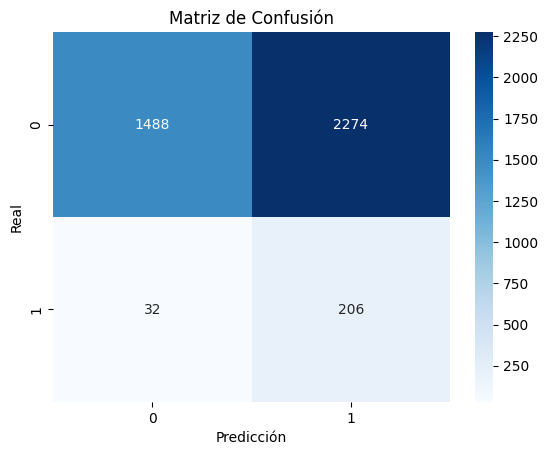

Classification Report:
              precision    recall  f1-score   support

  No CARAVAN       0.98      0.40      0.56      3762
     CARAVAN       0.08      0.87      0.15       238

    accuracy                           0.42      4000
   macro avg       0.53      0.63      0.36      4000
weighted avg       0.93      0.42      0.54      4000

AUC-ROC: 0.7252
Área bajo la curva Precision-Recall (PR AUC): 0.1563


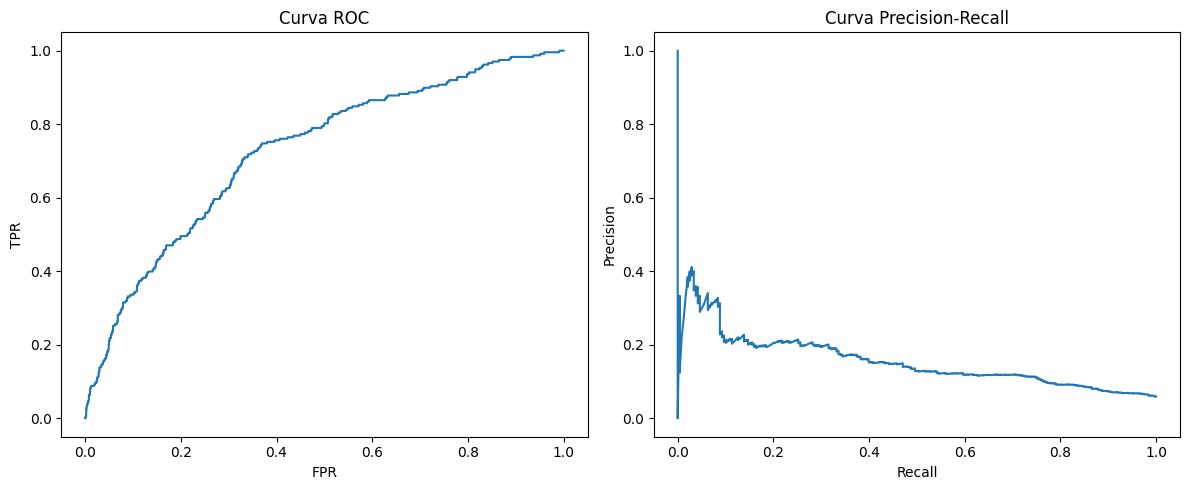

In [ ]:
evaluar_modelo(ensemble, X_test, y_test)